This project was done on pc running Ubuntu 20.04 with Tensorflow 2.7, Cuda 11.2 and cuDNN 8.1 on an RTX3080 GPU with 10Gb of memory

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, BatchNormalization, Dropout

In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.7.0


In [4]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_adroit_door',
 'd4rl_adroit_hammer',
 'd4rl_adroit_pen',
 'd4rl_adroit_relocate',
 'd4rl_mujoco_ant',
 'd4

I chose the malaria dataset, as that only has two classes. That makes the training (hopefully) somewhat faster

In [5]:
(test_ds, validate_ds, train_ds), metadata = tfds.load(
'malaria',
split=['train[:15%]', 'train[15%:30%]', 'train[30%:100%]'],
with_info=True,
as_supervised=True)

## EfficientNetB0

I chose the EfficientNetB0, as suggested by the lecturer. Maybe I will try some other models as well, if I have the time

In [6]:
# Create the base model from the pre-trained model EfficientNet B1
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224,224,3), 
    include_top=False,
    weights='imagenet', 
    classes=2, 
    pooling="avg",
)
base_model.trainable = False

# Preprocessing and input pipelines.

Next I will implement some sort of input pipeline. It will consist of resizing the datasets. The data will also be augmented with random flips and rotations. Note! Rescaling layer is included in the pretrained net.


In [7]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

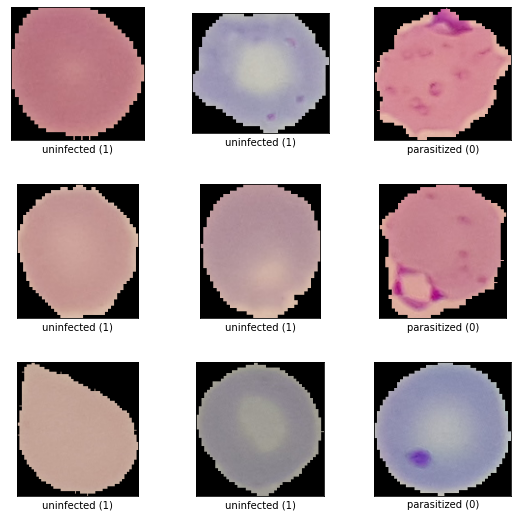

In [8]:
fig = tfds.show_examples(train_ds, metadata)

In [9]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, Resizing

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(1, fill_mode="constant"),
])

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
])

batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

# Show some cool examples of cells and illustration of data augmentation

In [10]:
get_label_name = metadata.features['label'].int2str

image_iterable = iter(train_ds)

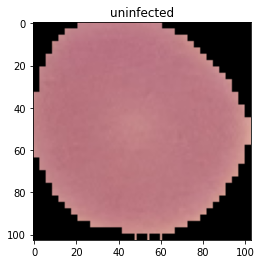

In [11]:
# rerun this cell to get other images

image, label = next(image_iterable)
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

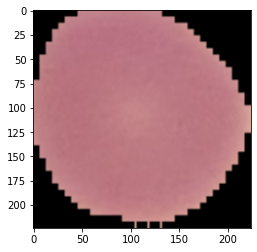

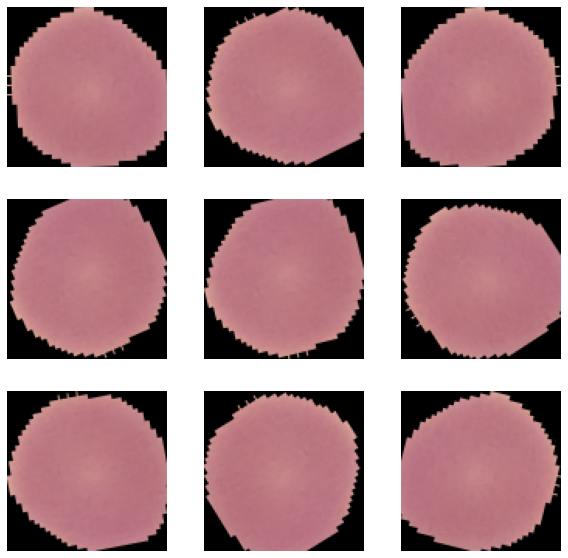

In [12]:
result = resize_and_rescale(image)
_ = plt.imshow(result/255)

# Add the image to a batch.
image = tf.expand_dims(image, 0)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [13]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

# It's time to build the model

In [14]:
# create new model on top
def create_model():
  inputs = Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)
  x = BatchNormalization()(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dense(1024, activation='relu', kernel_regularizer='l2')(x)
  x = Dropout(0.1)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  return Model(inputs, predictions)

# create the model

model = create_model()

# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

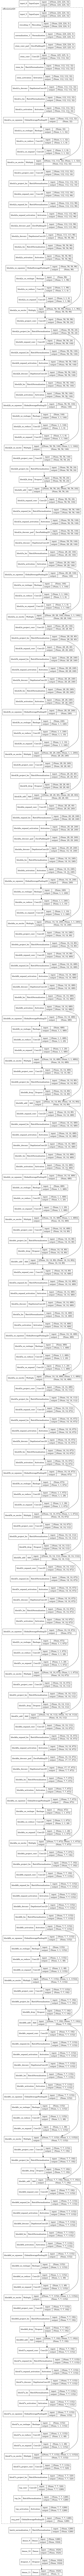

In [259]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy())

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

# Let's define checkpoint and early stopping callbacks

In [17]:
checkpoint_path = "models/transfer-net.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), cp_callback]

# Now it's time to establish a baseline for performance

In [18]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          verbose='auto',
          callbacks=callbacks)

Epoch 1/20
345/345 [==============================] - ETA: 0s - loss: 1.8503 - binary_accuracy: 0.9394
Epoch 00001: saving model to models/transfer-net.ckpt
345/345 [==============================] - 27s 62ms/step - loss: 1.8503 - binary_accuracy: 0.9394 - val_loss: 0.2372 - val_binary_accuracy: 0.9459
Epoch 2/20
344/345 [============================>.] - ETA: 0s - loss: 0.2408 - binary_accuracy: 0.9476
Epoch 00002: saving model to models/transfer-net.ckpt
345/345 [==============================] - 22s 62ms/step - loss: 0.2408 - binary_accuracy: 0.9476 - val_loss: 0.2181 - val_binary_accuracy: 0.9470
Epoch 3/20
344/345 [============================>.] - ETA: 0s - loss: 0.2097 - binary_accuracy: 0.9489
Epoch 00003: saving model to models/transfer-net.ckpt
345/345 [==============================] - 22s 61ms/step - loss: 0.2098 - binary_accuracy: 0.9490 - val_loss: 0.1860 - val_binary_accuracy: 0.9510
Epoch 4/20
344/345 [============================>.] - ETA: 0s - loss: 0.1882 - binary_ac

In [19]:
model.evaluate(val_ds)

44/44 [==============================] - 2s 48ms/step - loss: 0.1461 - binary_accuracy: 0.9561


[0.14611494541168213, 0.956095814704895]

# Plot history

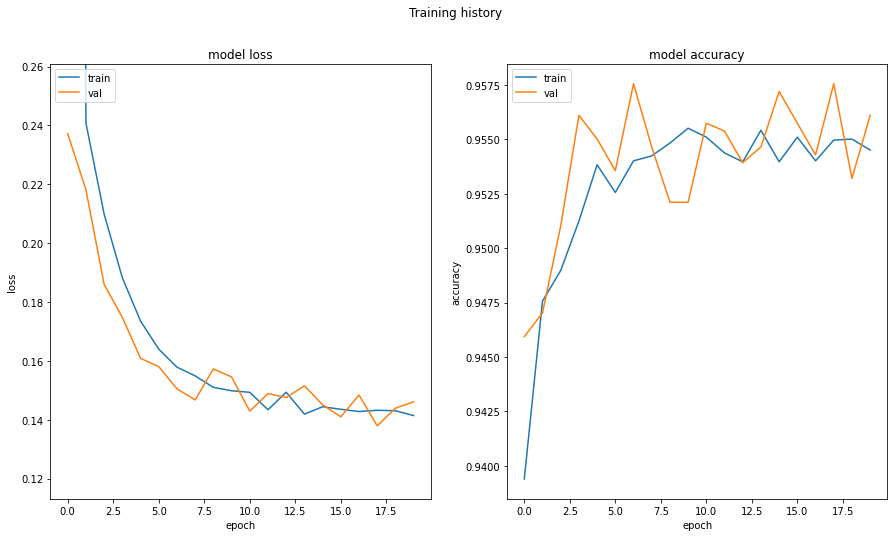

In [20]:
def plot_training_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
  fig.suptitle('Training history')

  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend(['train', 'val'], loc='upper left')
  ax1.set_ylim(min(history.history['loss'])*0.8, max(history.history['val_loss'])*1.1)

  ax2.plot(history.history['binary_accuracy'])
  ax2.plot(history.history['val_binary_accuracy'])
  ax2.set_title('model accuracy')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend(['train', 'val'], loc='upper left')

  plt.show()

plot_training_metrics(history)

# Fine-tuning the model

I tried fine-tuning the model a few layers at a time. That was very cumbersome. Training took very long, and performance was not improving much (often performance dropped). I decided to train the whole model at once, simply because I didnt have time to play around it anymore. Maybe I will come back to fine-tuning a layer at a time later.

In [21]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

44/44 - 2s - loss: 0.1461 - binary_accuracy: 0.9561 - 2s/epoch - 48ms/step
Restored model, validation accuracy: 95.61%
Number of layers in the base model:  238
Number of layers in the decision model:  -231
Epoch 20/49
345/345 [==============================] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9609
Epoch 00020: saving model to models/transfer-net-finetuned.ckpt
345/345 [==============================] - 114s 317ms/step - loss: 0.1271 - binary_accuracy: 0.9609 - val_loss: 0.1219 - val_binary_accuracy: 0.9594
Epoch 21/49
345/345 [==============================] - ETA: 0s - loss: 0.1185 - binary_accuracy: 0.9643
Epoch 00021: saving model to models/transfer-net-finetuned.ckpt
345/345 [==============================] - 110s 319ms/step - loss: 0.1185 - binary_accuracy: 0.9643 - val_loss: 0.1143 - val_binary_accuracy: 0.9612
Epoch 22/49
345/345 [==============================] - ETA: 0s - loss: 0.1124 - binary_accuracy: 0.9664
Epoch 00022: saving model to models/transfer-net-finetun

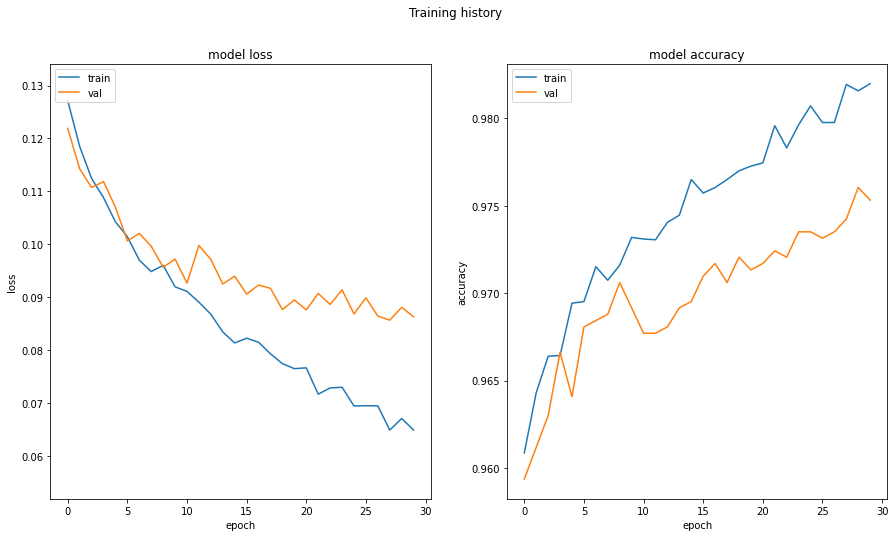

44/44 - 2s - loss: 0.0863 - binary_accuracy: 0.9753 - 2s/epoch - 41ms/step
Fine-tuned model, validation accuracy: 97.53%


In [22]:
# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
print("Number of layers in the decision model: ", len(model.layers) - len(base_model.layers))

#for layer in base_model.layers:
#  layer.trainable = False

# freeze the base model layers
#for layer in base_model.layers: # Here you could fine tune the model layer by layer, we will try whole model
#  layer.trainable = True

# I do realize the above hassle was redundand. First I set all layers not trainabel, and then I set all layers to trainable. This 
# is just so that I don't forget the idea was to fine-tune a few layers at a time.

# Unfreeze the base model
base_model.trainable = True

adam = tf.keras.optimizers.Adam(
    learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

ft_checkpoint_path = "models/transfer-net-finetuned.ckpt"
ft_checkpoint_dir = os.path.dirname(ft_checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), cp_callback]

fine_tune_epochs = 30
total_epochs =  history.epoch[-1] + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Fine-tuned model, validation accuracy: {:5.2f}%".format(100 * acc))

## Fine-tune with learning rate scheduler

Let's try fine-tuning the model for another round with initially larger learning rate, but with the learning rate dropping exponentially after some initial epochs.

In [23]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

44/44 - 3s - loss: 0.0863 - binary_accuracy: 0.9753 - 3s/epoch - 60ms/step
Restored model, accuracy: 97.53%


Epoch 49/78
345/345 [==============================] - ETA: 0s - loss: 0.1719 - binary_accuracy: 0.9511
Epoch 00049: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 114s 318ms/step - loss: 0.1719 - binary_accuracy: 0.9511 - val_loss: 0.2074 - val_binary_accuracy: 0.9470 - lr: 0.0010
Epoch 50/78
345/345 [==============================] - ETA: 0s - loss: 0.1395 - binary_accuracy: 0.9588
Epoch 00050: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 107s 310ms/step - loss: 0.1395 - binary_accuracy: 0.9588 - val_loss: 0.1367 - val_binary_accuracy: 0.9604 - lr: 0.0010
Epoch 51/78
345/345 [==============================] - ETA: 0s - loss: 0.1272 - binary_accuracy: 0.9609
Epoch 00051: saving model to models/transfer-net-finetuned-2.ckpt
345/345 [==============================] - 107s 309ms/step - loss: 0.1272 - binary_accuracy: 0.9609 - val_loss: 0.1188 - val_binary_accuracy: 0.9648 - lr: 0.0010
Epoc

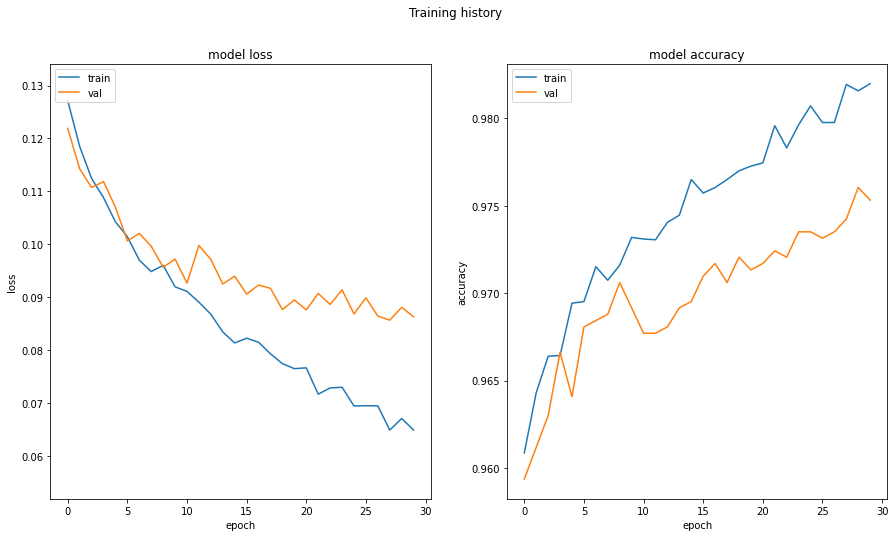

44/44 - 2s - loss: 0.0733 - binary_accuracy: 0.9742 - 2s/epoch - 46ms/step
Fine-tuned model, accuracy: 97.42%


In [25]:
# Exponential decay after certain number of epochs
def scheduler(epoch, lr):
  if epoch < history_fine.epoch[-1] + 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Re-freeze all base model layers
#for layer in base_model.layers:
#  layer.trainable = False

# Open up all layers of the base model
#for layer in base_model.layers:
#  layer.trainable = True

# Unfreeze the base model
base_model.trainable = True

# Explicitly define optimizer with low learning rate
adam = tf.keras.optimizers.Adam(
    learning_rate=1e-03, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

# Re-compile model
model.compile(optimizer=adam, 
              loss='binary_crossentropy',
              metrics=tf.keras.metrics.BinaryAccuracy())

# Define new path to save weights
ft_checkpoint_path_2 = "models/transfer-net-finetuned-2.ckpt"
ft_checkpoint_dir_2 = os.path.dirname(ft_checkpoint_path_2)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ft_checkpoint_path_2,
                                                 save_weights_only=True,
                                                 verbose=1)
# Define callbacks for training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), cp_callback, lr_callback]

fine_tune_epochs = 30
total_epochs = history_fine.epoch[-1] + fine_tune_epochs

history_fine_2 = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=total_epochs - fine_tune_epochs,
                         validation_data=val_ds,
                         callbacks=callbacks)

plot_training_metrics(history_fine)
# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

In [27]:
# Loads the weights from previous checkpoint
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored baseline model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored fine-tuned model, accuracy: {:5.2f}%".format(100 * acc))

# Loads the weights from previous checkpoint
model.load_weights(ft_checkpoint_path_2)

# Re-evaluate the model
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored final model, accuracy: {:5.2f}%".format(100 * acc))

44/44 - 2s - loss: 0.1636 - binary_accuracy: 0.9510 - 2s/epoch - 45ms/step
Restored baseline model, accuracy: 95.10%
44/44 - 2s - loss: 0.1106 - binary_accuracy: 0.9688 - 2s/epoch - 46ms/step
Restored fine-tuned model, accuracy: 96.88%
44/44 - 2s - loss: 0.0896 - binary_accuracy: 0.9695 - 2s/epoch - 46ms/step
Restored final model, accuracy: 96.95%


# Results

Performance of baseline was about 95.10%. After first round of finetuning with low learning rate performance was 96.88%. After the final round of fine-tuning with learning rate scheduler, the final performance on test set was 96.95%. Not great, not terrible. Could definitely be higher.

## Examples of erroneous predictions

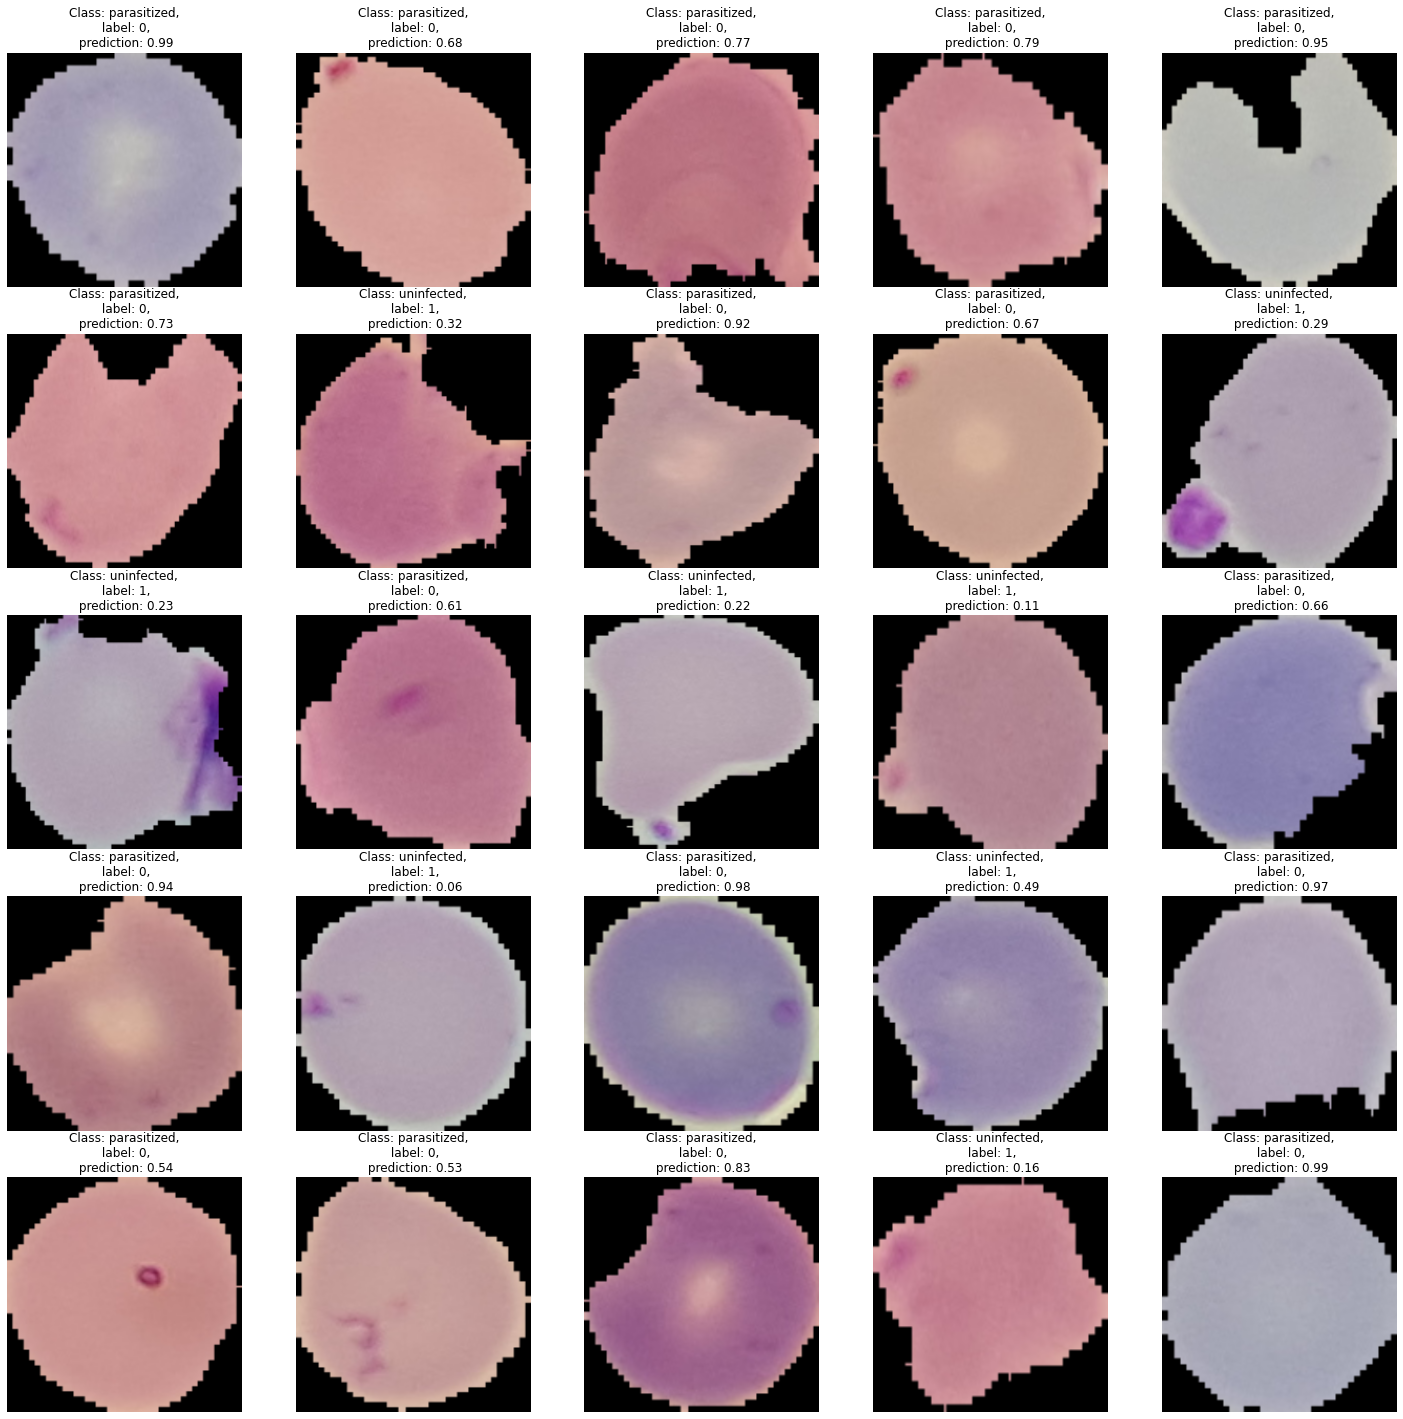

In [28]:
plt.figure(figsize=(25, 25))

false_predictions = 0

for set in test_ds:

    if false_predictions == 25:
      break

    predictions = model.predict(set[0])
    for i in range(len(predictions)):

        label = int(set[1][i])

        if label != round(predictions[i][0]):
          false_predictions += 1
          label_name = get_label_name(label)
          prediction = predictions[i]
          ax = plt.subplot(5, 5, false_predictions)
          plt.imshow(set[0][i]/255)
          plt.axis("off")
          ax.set_title(f'Class: {label_name},\n label: {label},\n prediction: {"%.2f" % prediction[0]}')
          if false_predictions == 25:
            break
plt.show()